In [1]:
%%capture --no-display
! pip install scipy
! pip install matplotlib 
! pip install seaborn
! pip install plotly

In [1]:
%load_ext autoreload

import json
import numpy as np
import pandas as pd
from src.pyipums.parse_xml import read_ipums_ddi
from src.pyipums.clean_data import IpumsCleaner
from ipumspy import readers, ddi
from matplotlib import pyplot as plt
import plotly
import plotly.io as pio

import seaborn as sns
import matplotlib as mpl
from IPython.core.display import display

plt.rcParams["figure.figsize"]=12,8  # Set figure size for the notebook
sns.set(style="whitegrid")           # set seaborn whitegrid theme

plotly.offline.init_notebook_mode(connected=True)

# pio.renderers.default = 'iframe' # or 'notebook' or 'colab' or 'jupyterlab'
# pio.renderers.default = 'jupyterlab'
# This is the one that works
pio.renderers.default = 'iframe'

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_66859/2639721591.py:15: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


In [2]:
from src.pyipums.clean_data import IpumsCleaner

In [3]:
from utils import *

In [4]:
ddi_file_path = "./cps_00003.xml"
data_file_path = "./cps_00003.dat.gz"

ddi_codebook = readers.read_ipums_ddi(ddi_file_path)

/Users/franciscojavierarceo/.pyenv/versions/3.8.16/lib/python3.8/site-packages/ipumspy/readers.py:47: CitationWarning:

Use of data from IPUMS is subject to conditions including that users should cite the data appropriately.
See the `ipums_conditions` attribute of this codebook for terms of use.
See the `ipums_citation` attribute of this codebook for the appropriate citation.



In [5]:
ipums_df = readers.read_microdata(
    ddi_codebook,
    data_file_path,
    nrows=1e7,
    subset=ipums_xvars,
)

In [6]:
# Dropping any records withought a weight
wdf = ipums_df[ipums_df['ASECWT'].isnull()==False].reset_index(drop=True)

In [7]:
df = IpumsCleaner(wdf, ddi_codebook).clean_data()

In [8]:
df['RACE_ORIGINAL'] = df['RACE']

x = pt(None, df, 'Race', 'ASECWT')

races = list(x.iloc[0:4,0].values)
df['Race_top_5'] = df['Race'].apply(lambda x: x if x in races else 'Other')
df['Race_full'] = np.where(df['Hispanic']!='Not Hispanic', 'Hispanic', df['Race_top_5'])

# Visualizations

In [203]:
def ptbarplot2(xdf, col, gvar, wvar, colors=['red', 'blue'], title='', sort_var='Percent_x', ascending=True, labels=None, ddi=None, n=10, output=False, fmt="%.1f%%"):
    if labels is None:
        labels = sorted(list(xdf[col].unique()))

    for i, label in enumerate(labels):
        if i==0:
            tm = pt(ddi, xdf[xdf[col]==label], gvar, wvar)
            tm.rename({"Percent": f"Percent_{label}"}, axis=1, inplace=True)
        else:
            tplus1 = pt(ddi, xdf[xdf[col]==label], gvar, wvar)
            tplus1.rename({"Percent": f"Percent_{label}"}, axis=1, inplace=True)
            tm = tm.merge(tplus1, on=gvar)

    if sort_var == 'Percent_x':
        sort_var = f"Percent_{label}"

    tm = tm.sort_values(by=sort_var, ascending=ascending)
        
    tm[[c for c in tm.columns if 'Percent' in c]] = tm[
        [c for c in tm.columns if 'Percent' in c]
    ] * 100.
    try:
        ylabel = ddi.get_variable_info(gvar).label.title()
    except:
        ylabel = gvar
    
    g = tm.reset_index(drop=True).loc[0:n].sort_values(by=sort_var, ascending=True).plot.barh(
        x=gvar,
        y=[c for c in tm.columns if 'Percent' in c],
        color=colors,
        label=labels,
        title=title,
        figsize=(12, 8),
        legend='lower right',
    )

    for container in g.containers:
        g.bar_label(container, fmt=fmt, padding=2)

    g.legend(labels, loc='lower right')
    g.set_ylabel(ylabel)
    g.set_xlabel("Within Group Percent of Data")
    if output:
        return tm

In [177]:
pt(ddi_codebook, df, 'SEX')

,SEX,code,count,Percent
0,Female,2,78082,0.511235
1,Male,1,74650,0.488765


In [178]:
df['Gender'] = np.where(df['SEX'] == 1, 'Male', 'Female')
df['Hispanic or Not - Sex'] = df['Hispanic or Not'] + " - " + df['Gender']

In [179]:
pt(None, df, 'Hispanic or Not')

,Hispanic or Not,count,Percent
0,Not Hispanic,122032,0.798994
1,Hispanic,30700,0.201006


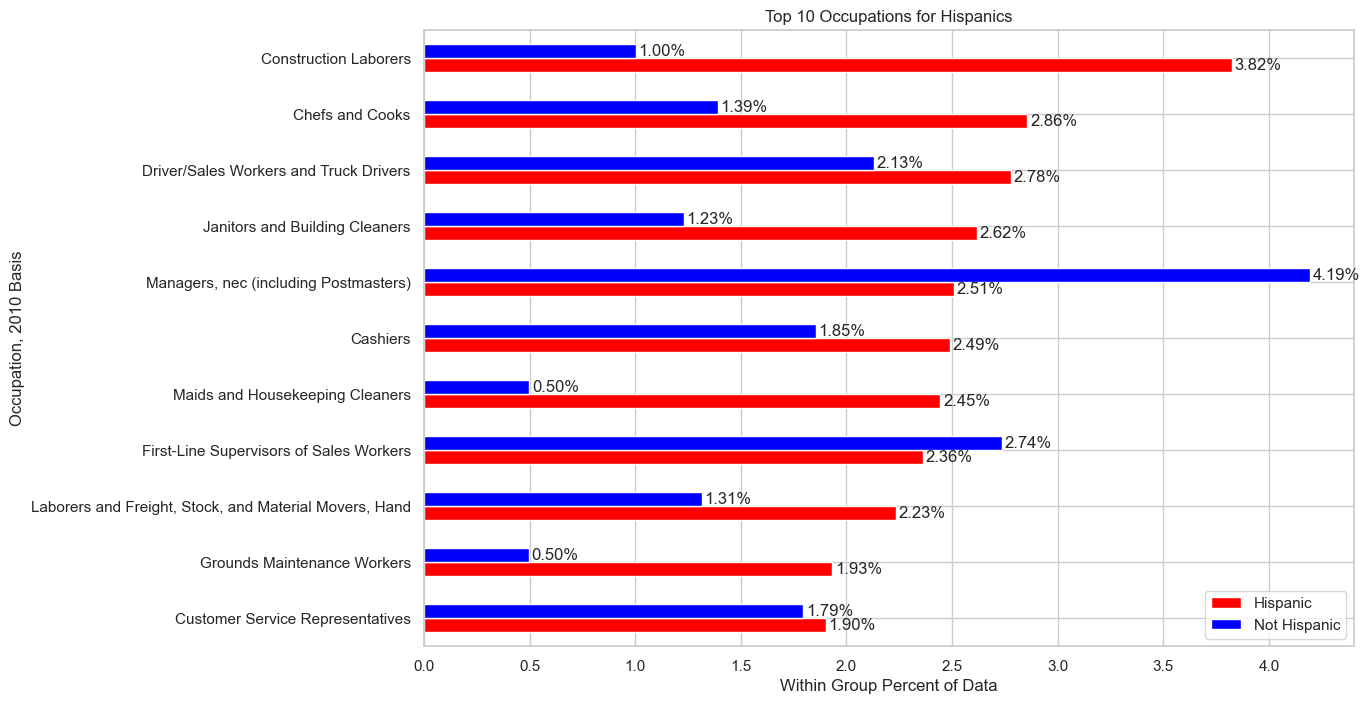

In [208]:
ptbarplot2(
    xdf=df[df['Class_of_worker'] !='NIU'], 
    col='Hispanic or Not', 
    gvar='OCC2010', 
    wvar='ASECWT', 
    colors=['red', 'blue', 'purple', 'orange'],
    title='Top 10 Occupations for Hispanics', 
    ddi=ddi_codebook,
    sort_var='Percent_Hispanic',
    ascending=False,
    n=10,
    output=False,
    fmt="%.2f%%",
)

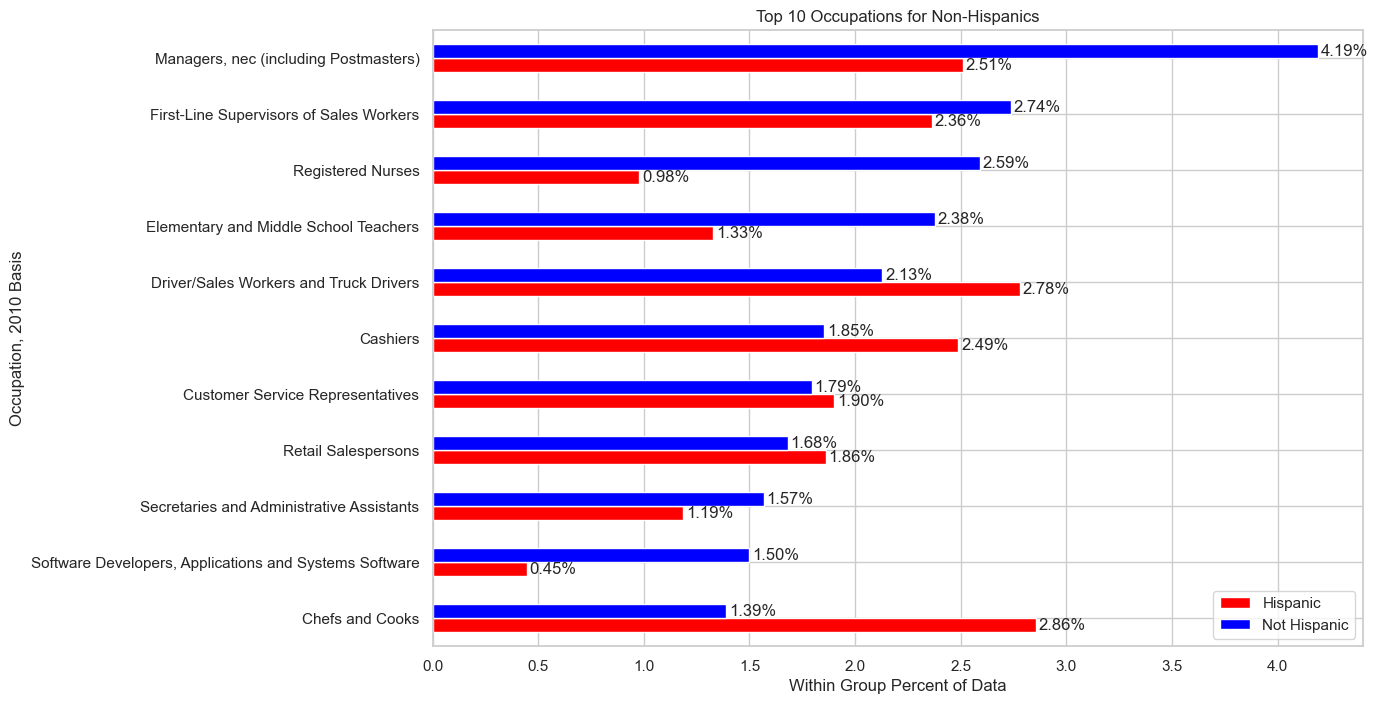

In [209]:
ptbarplot2(
    xdf=df[df['Class_of_worker'] !='NIU'], 
    col='Hispanic or Not', 
    gvar='OCC2010', 
    wvar='ASECWT', 
    colors=['red', 'blue'],
    title='Top 10 Occupations for Non-Hispanics', 
    ddi=ddi_codebook,
    sort_var='Percent_Not Hispanic',
    ascending=False,
    n=10,
    output=False,
    fmt="%.2f%%",
)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_66859/1773662181.py:12: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'count_x', 'code_x', 'raw_count_x', 'raw_percent_x'} in the result is deprecated and will raise a MergeError in a future version.



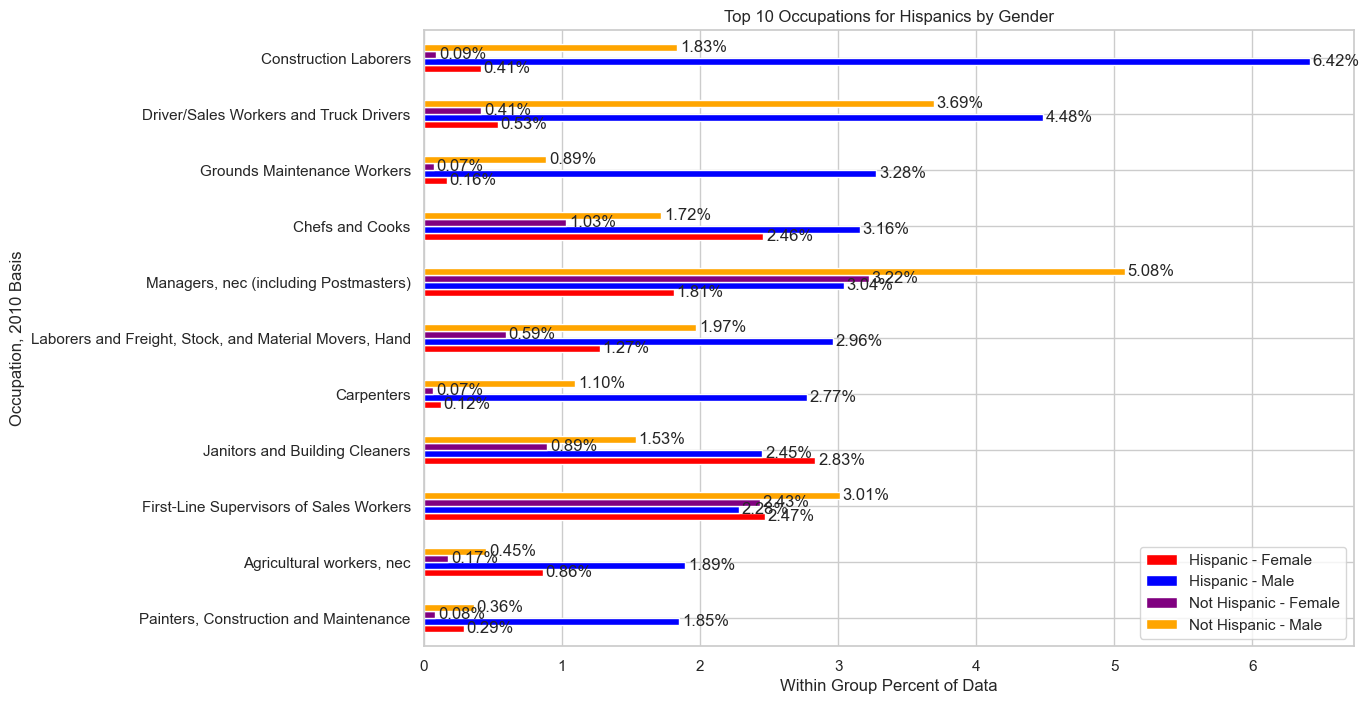

In [210]:
xtm = ptbarplot2(
    xdf=df[df['Class_of_worker'] !='NIU'], 
    col='Hispanic or Not - Sex', 
    gvar='OCC2010', 
    wvar='ASECWT', 
    colors=['red', 'blue', 'purple', 'orange'],
    title='Top 10 Occupations for Hispanics by Gender', 
    ddi=ddi_codebook,
    sort_var='Percent_Hispanic - Male',
    ascending=False,
    n=10,
    output=True,
    fmt="%.2f%%",
)

In [201]:
xtm['Percent_Not Hispanic - Male'].max()

5.076586550388847

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_66859/1773662181.py:12: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'count_x', 'code_x', 'raw_count_x', 'raw_percent_x'} in the result is deprecated and will raise a MergeError in a future version.



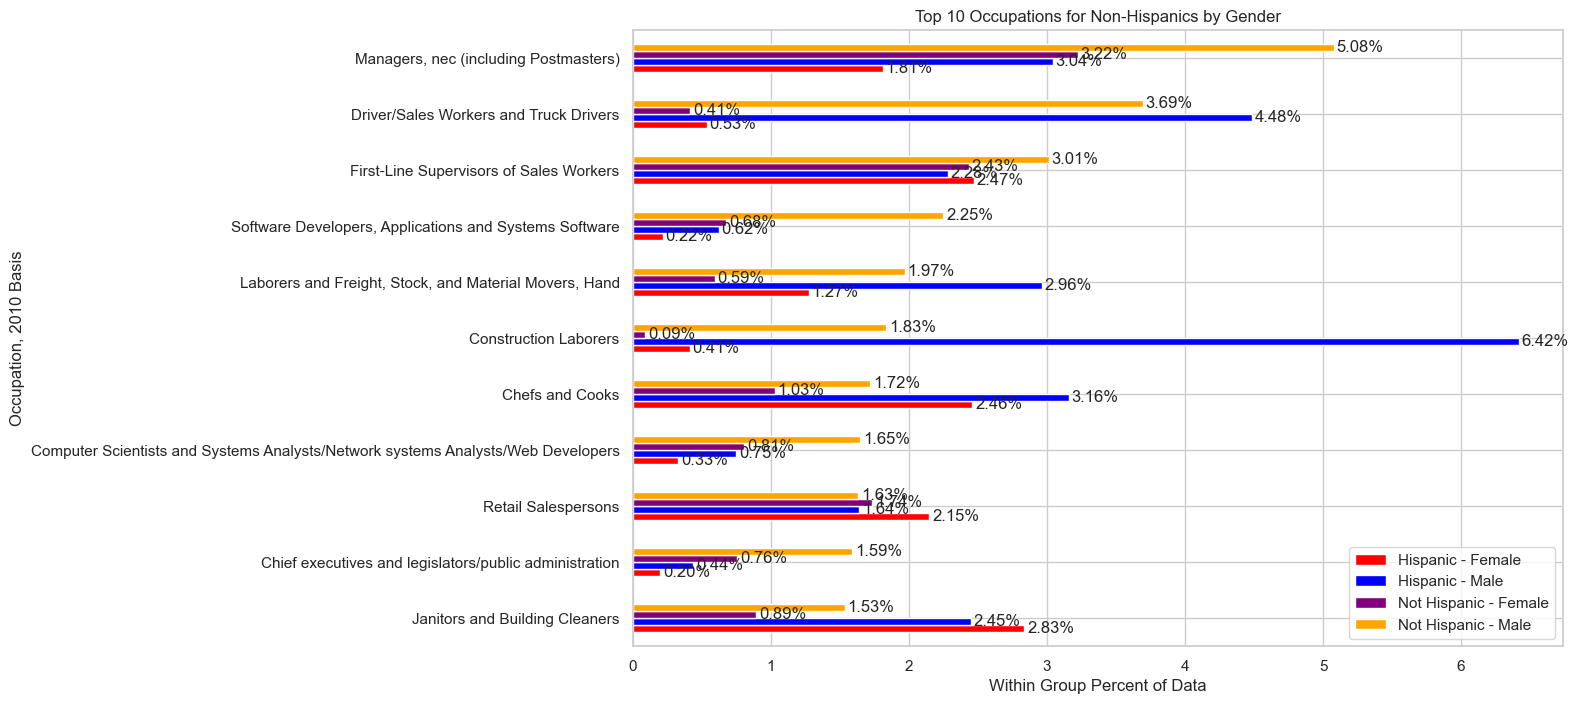

In [211]:
xtm = ptbarplot2(
    xdf=df[df['Class_of_worker'] !='NIU'], 
    col='Hispanic or Not - Sex', 
    gvar='OCC2010', 
    wvar='ASECWT', 
    colors=['red', 'blue', 'purple', 'orange'],
    title='Top 10 Occupations for Non-Hispanics by Gender', 
    ddi=ddi_codebook,
    sort_var='Percent_Not Hispanic - Male',
    ascending=False,
    n=10,
    output=True,
    fmt="%.2f%%",
)

/var/folders/0f/j3495cjn7f71jcy4ffxb049c0000gn/T/ipykernel_66859/1773662181.py:12: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'count_x', 'code_x', 'raw_count_x', 'raw_percent_x'} in the result is deprecated and will raise a MergeError in a future version.



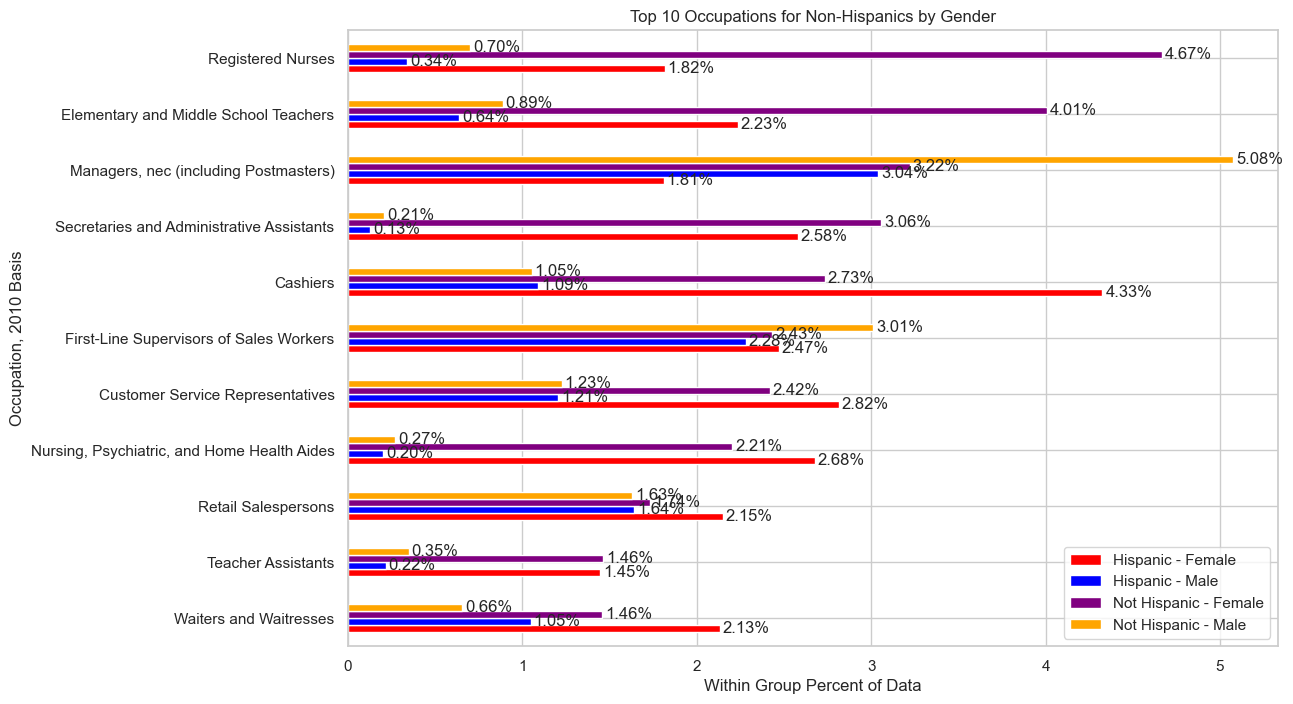

In [212]:
xtm = ptbarplot2(
    xdf=df[df['Class_of_worker'] !='NIU'], 
    col='Hispanic or Not - Sex', 
    gvar='OCC2010', 
    wvar='ASECWT', 
    colors=['red', 'blue', 'purple', 'orange'],
    title='Top 10 Occupations for Non-Hispanics by Gender', 
    ddi=ddi_codebook,
    sort_var='Percent_Not Hispanic - Female',
    ascending=False,
    n=10,
    output=True,
    fmt="%.2f%%",
)

# Would be fun to do Oaxaca Blinder Decomposition: https://www.statsmodels.org/dev/generated/statsmodels.stats.oaxaca.OaxacaBlinder.html#statsmodels.stats.oaxaca.OaxacaBlinder

# Visualizations

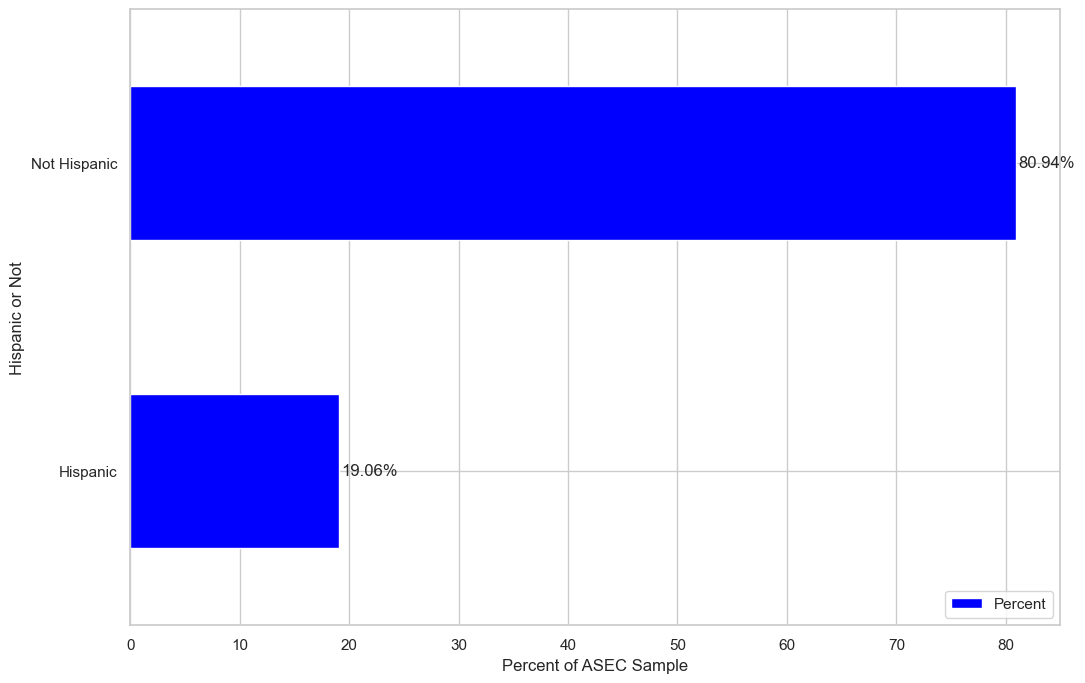

In [10]:
ptbarplot(None,  df, 'Hispanic or Not', 'ASECWT')

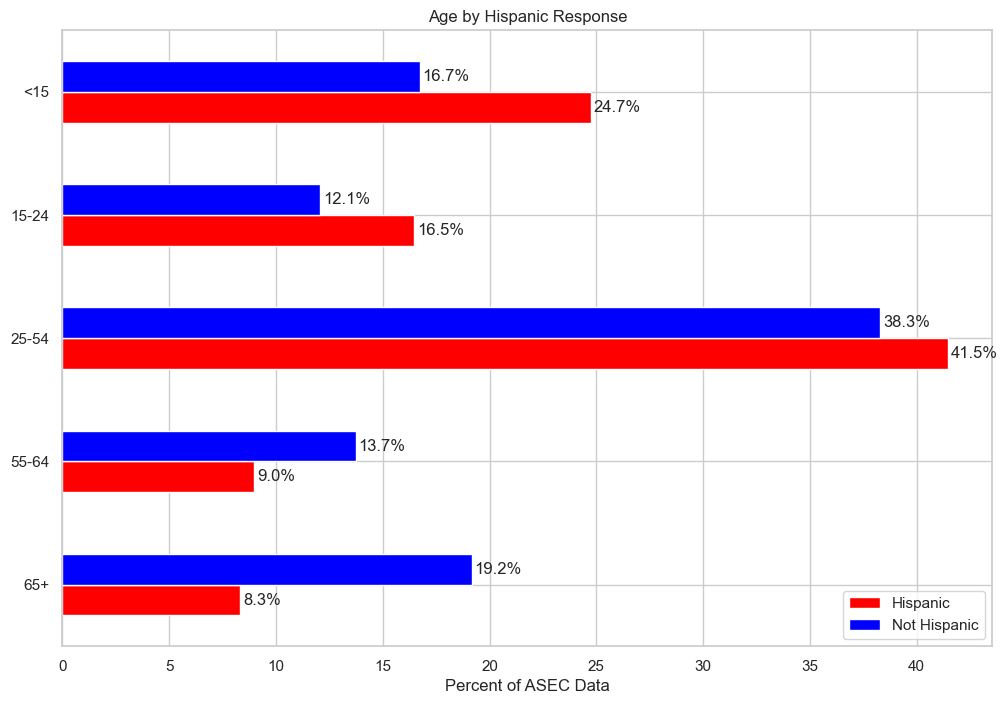

In [11]:
ptbarplot2(df, 'Hispanic or Not', 'Age Bucket', 'ASECWT', title='Age by Hispanic Response', sort_var='Age Bucket', ascending=False)

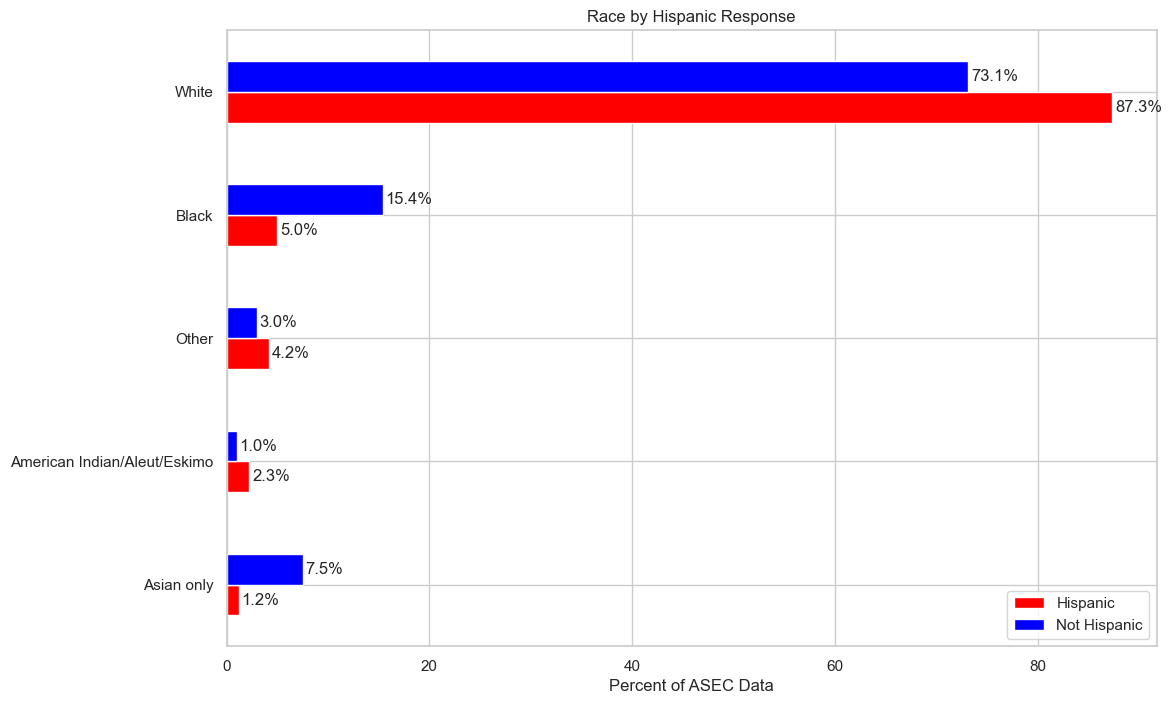

In [12]:
ptbarplot2(df, 'Hispanic or Not', 'Race_top_5', 'ASECWT', title='Race by Hispanic Response')

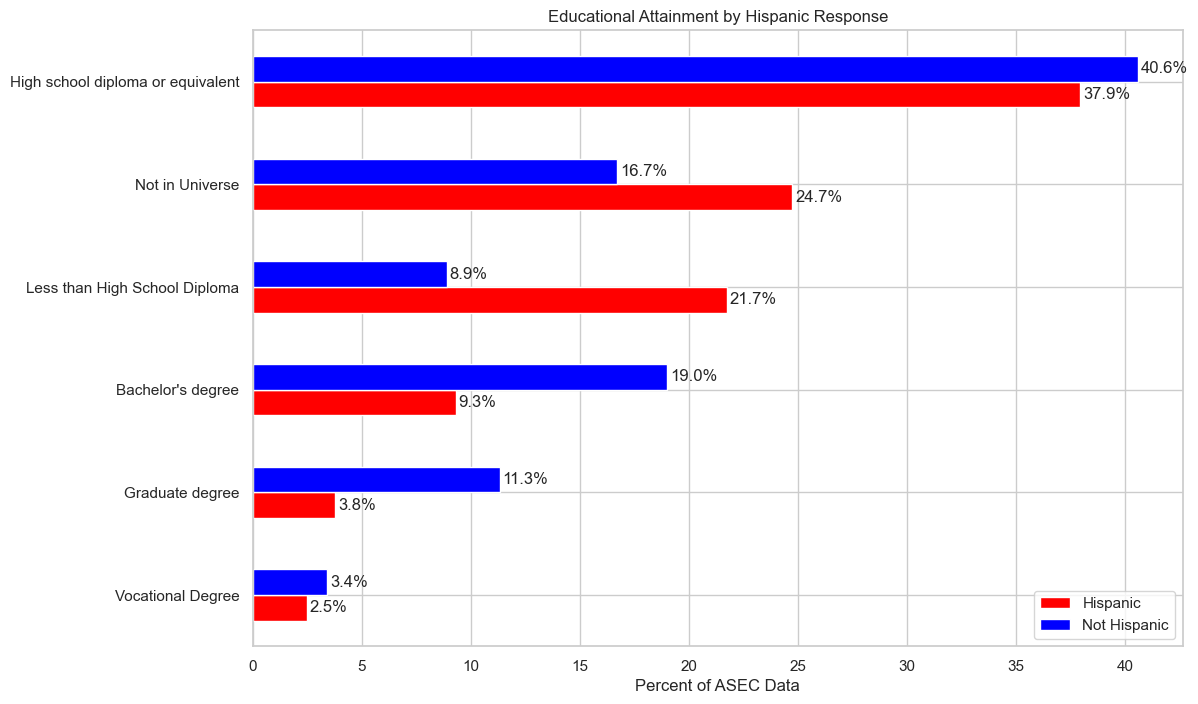

In [13]:
ptbarplot2(df, 'Hispanic or Not', 'Educational Attainment', 'ASECWT', title='Educational Attainment by Hispanic Response')

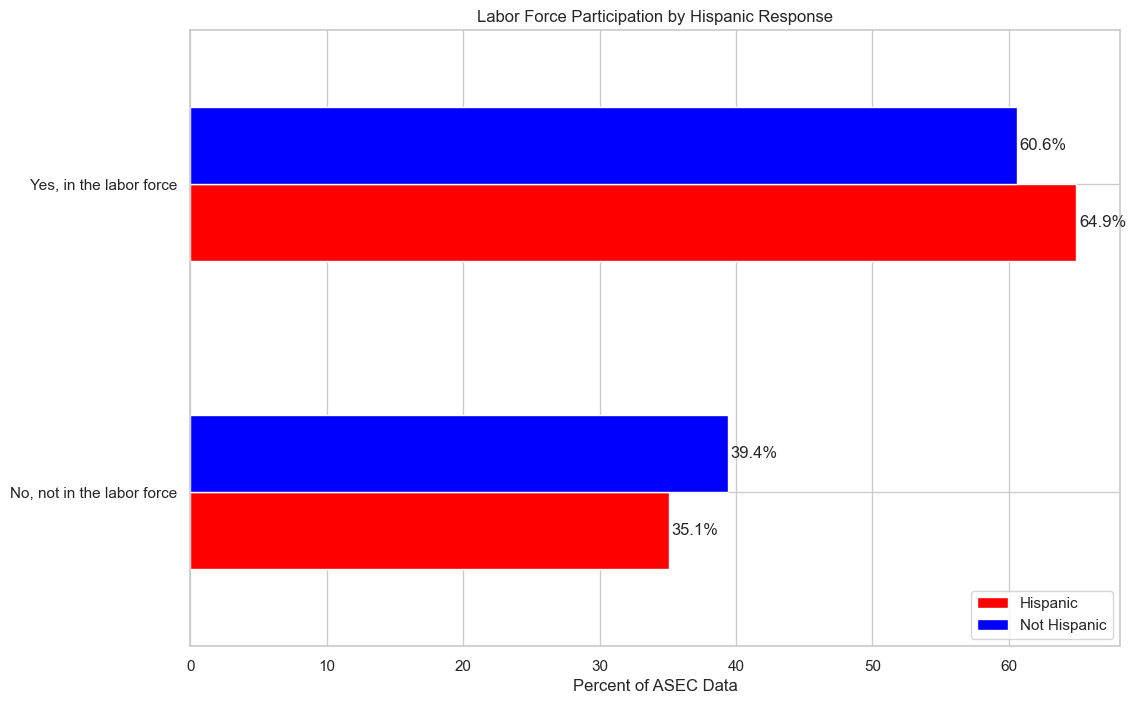

In [14]:
ptbarplot2(df[df['Labor Force']!='NIU'], 'Hispanic or Not', 'Labor Force', 'ASECWT', title='Labor Force Participation by Hispanic Response')

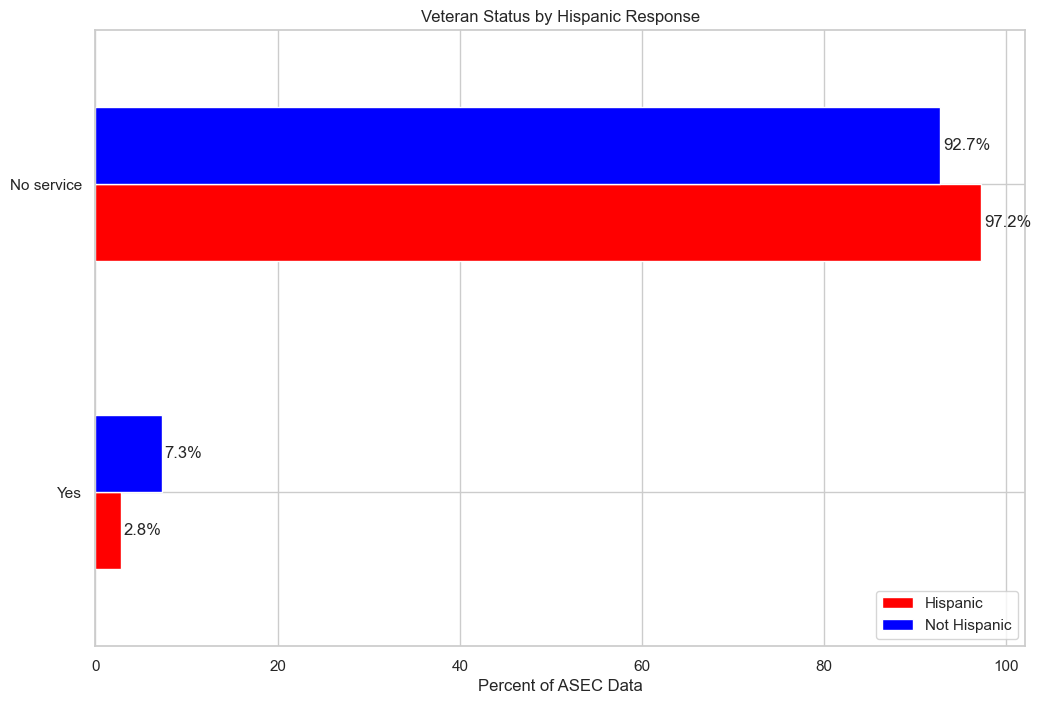

In [15]:
ptbarplot2(df[df['Veteran_Status'] !='NIU'], 'Hispanic or Not', 'Veteran_Status', 'ASECWT', title='Veteran Status by Hispanic Response')

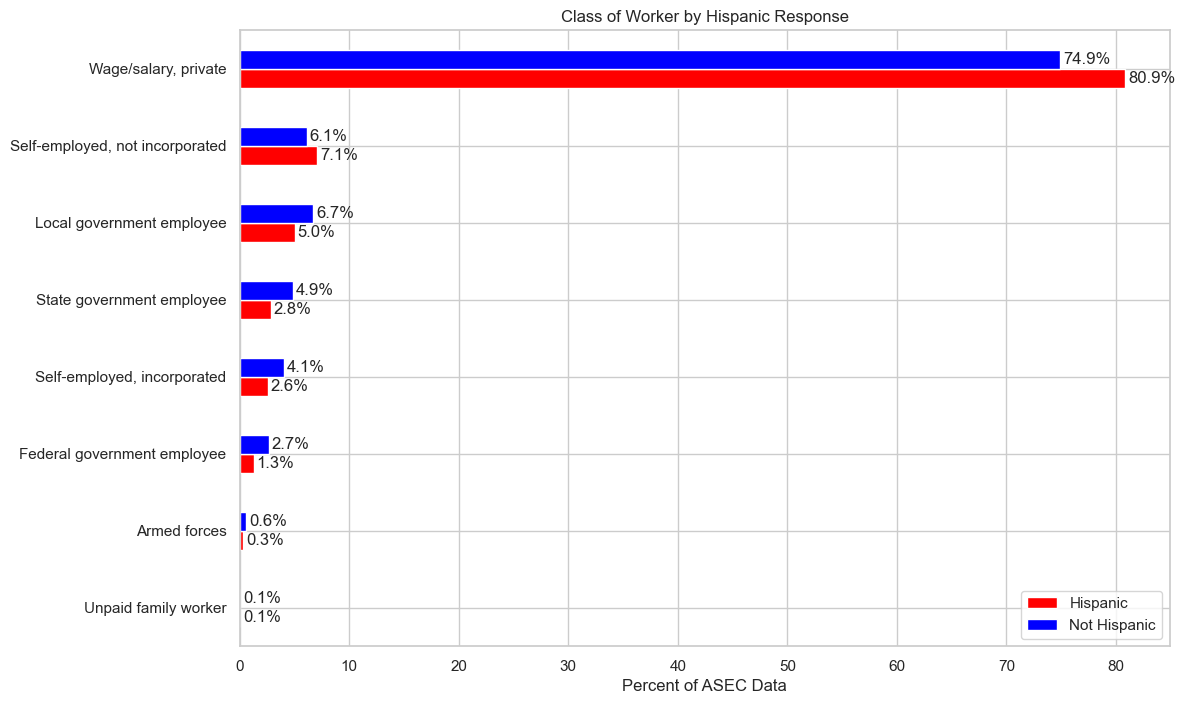

In [16]:
ptbarplot2(df[df['Class_of_worker'] !='NIU'], 'Hispanic or Not', 'Class_of_worker', 'ASECWT', title='Class of Worker by Hispanic Response')

In [ ]:
def ptbarplot(ddi, df, xvar, wvar, color="blue", out=False):
    x = pt(ddi, df, xvar, wvar)
    try:
        ylabel = ddi.get_variable_info(xvar).label.title()
    except:
        ylabel = xvar
    x["Percent"] = (x["Percent"] * 100.0).round(2)

    y = (
        x[["Percent", xvar]]
        .sort_values(by="Percent", ascending=False)
        .reset_index(drop=True)
        .loc[0:30]
    )


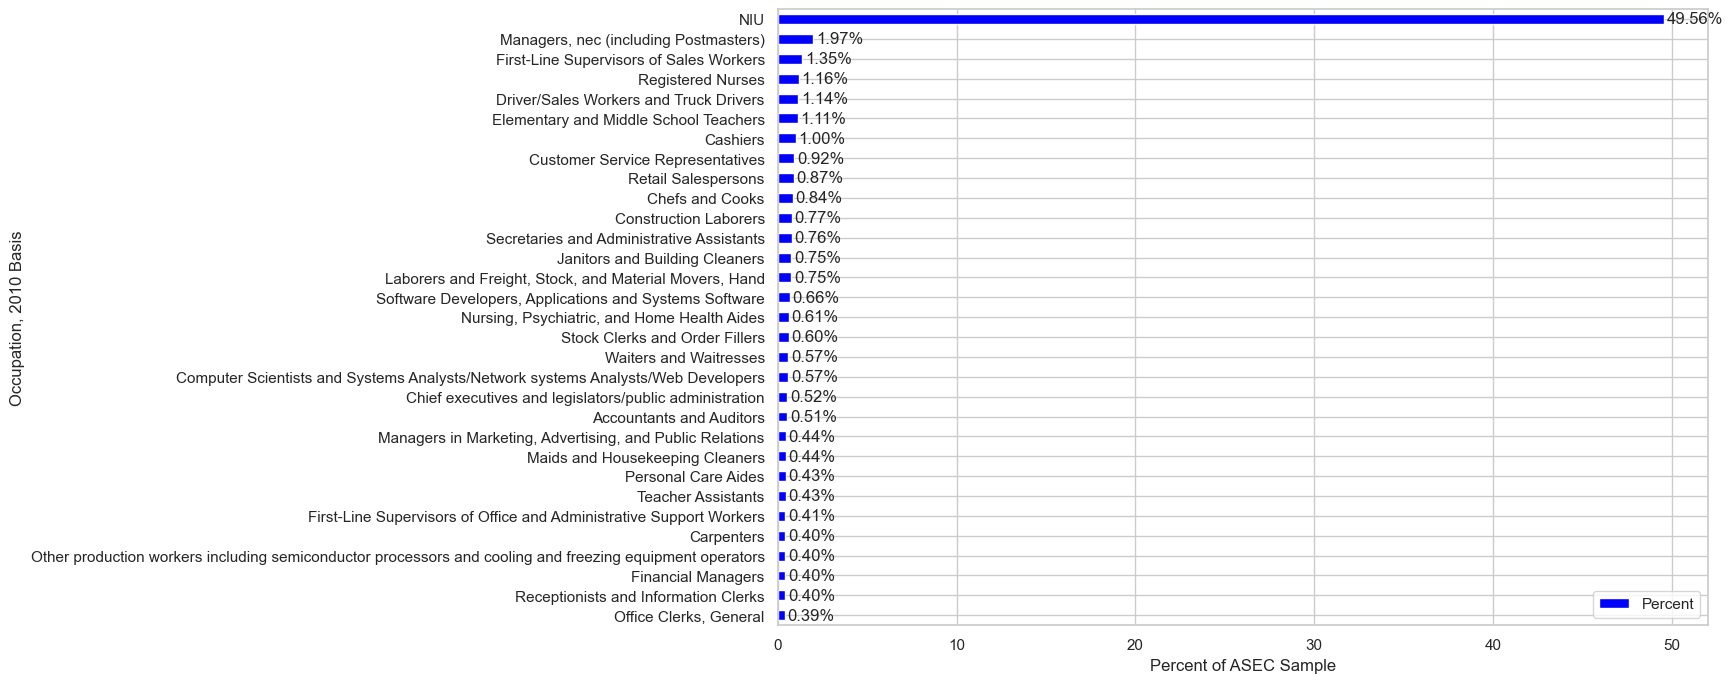

In [24]:
ptbarplot(ddi_codebook, df, 'OCC2010', 'ASECWT', color='blue')

In [23]:
df['OCC2010'].value_counts()

9999    78249
430      2944
4700     2026
2310     1698
3130     1694
        ...  
7830        3
8730        3
8910        2
7030        1
8850        1
Name: OCC2010, Length: 423, dtype: Int64

reducing records from 73863 to 71418
reducing groups from 9 to 6


/Users/franciscojavierarceo/github/pypums/utils.py:205: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



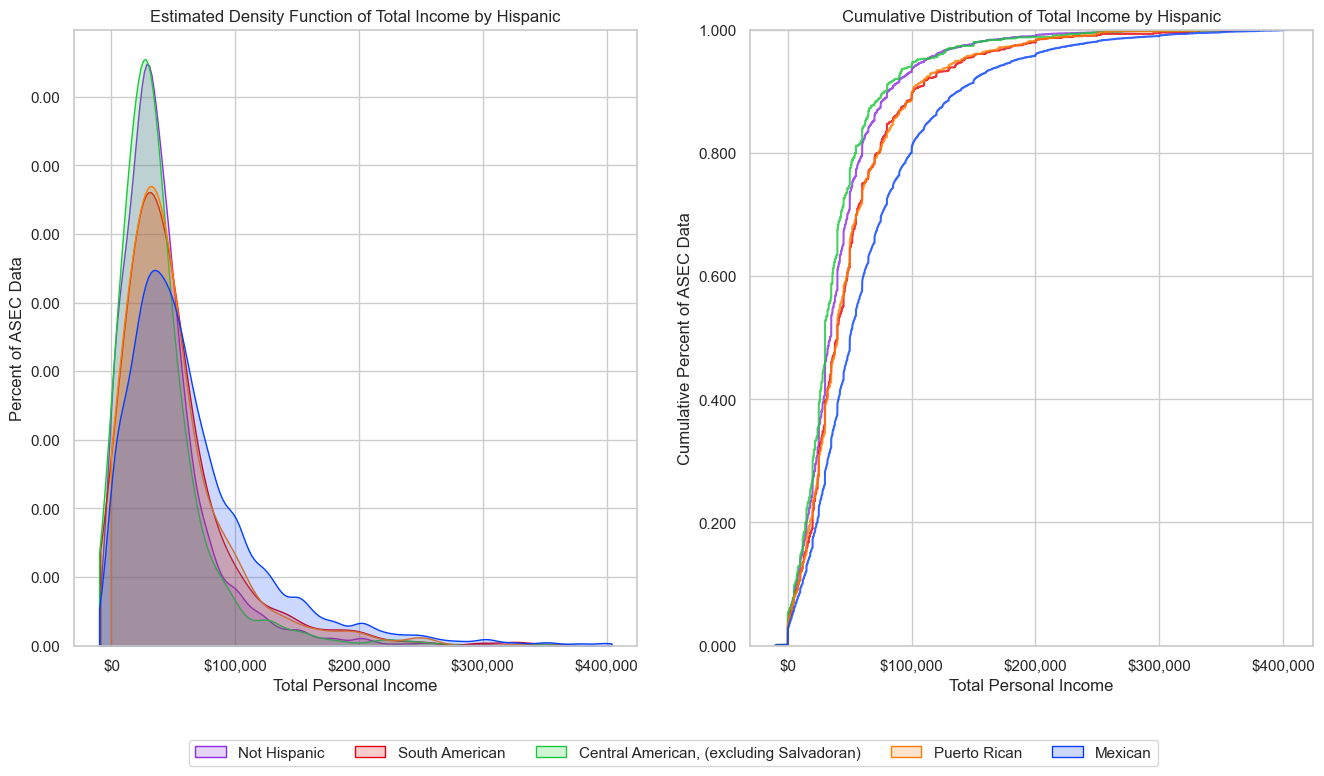

In [17]:
den_cdf_plot_by_x(
    ddi_codebook,
    df[df['LABFORCE']==2], 'Hispanic', 'INCTOT', 'ASECWT', 
    k=6, bbox=(0.5, -0.05), legend_ncol=5, 
    max_percentile=0.99,
    # den_title="Total Personal Income by Hispanic Response for Respondents in the Labor Force",
)

/Users/franciscojavierarceo/github/pypums/utils.py:463: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Wage Income
Hispanic or Not,
Hispanic,20593.641275
Not Hispanic,30202.828181


/Users/franciscojavierarceo/github/pypums/utils.py:504: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



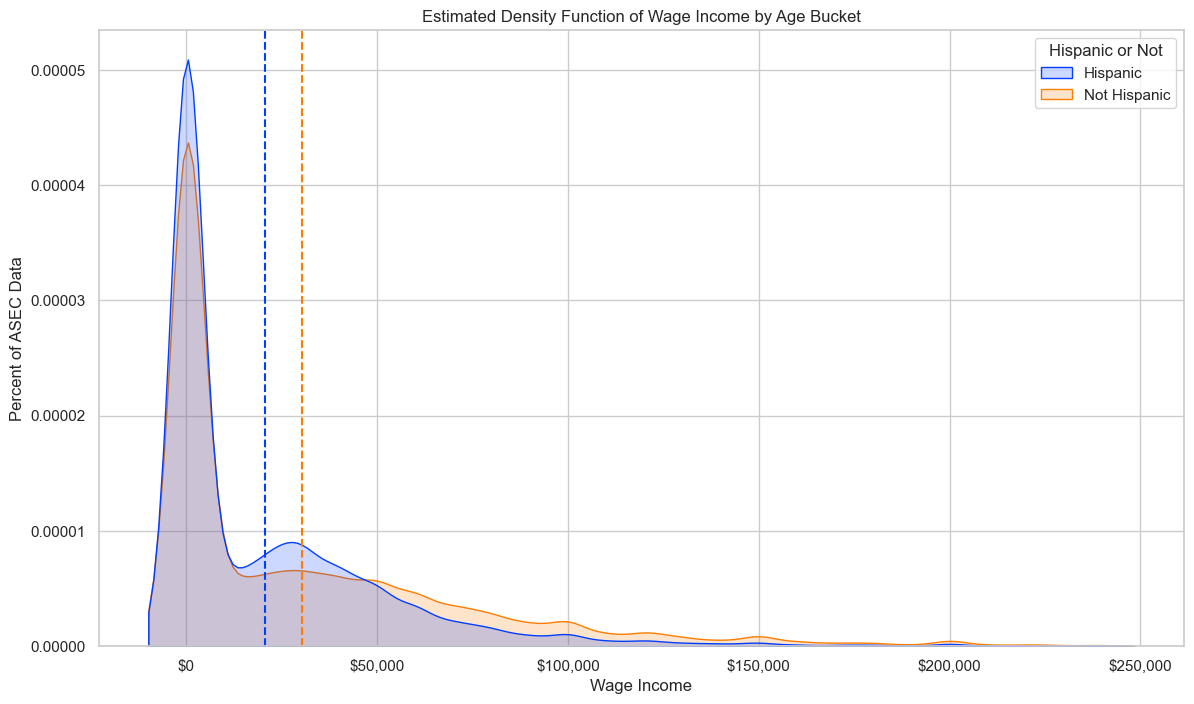

In [18]:
den_plot_by_x(
    ddi_codebook,
    df, 
    'Hispanic or Not',
    'Wage Income', 
    'ASECWT', 
    k=None, bbox=(0.5, -0.01), 
    legend_ncol=10,
    max_percentile=.99, 
    addvline=True, 
    den_title='Estimated Density Function of Wage Income for Hispanics vs Non-Hispanics',
)

/Users/franciscojavierarceo/github/pypums/utils.py:463: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Investment Income
Hispanic or Not,
Hispanic,442.987507
Not Hispanic,1258.420590


/Users/franciscojavierarceo/github/pypums/utils.py:504: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



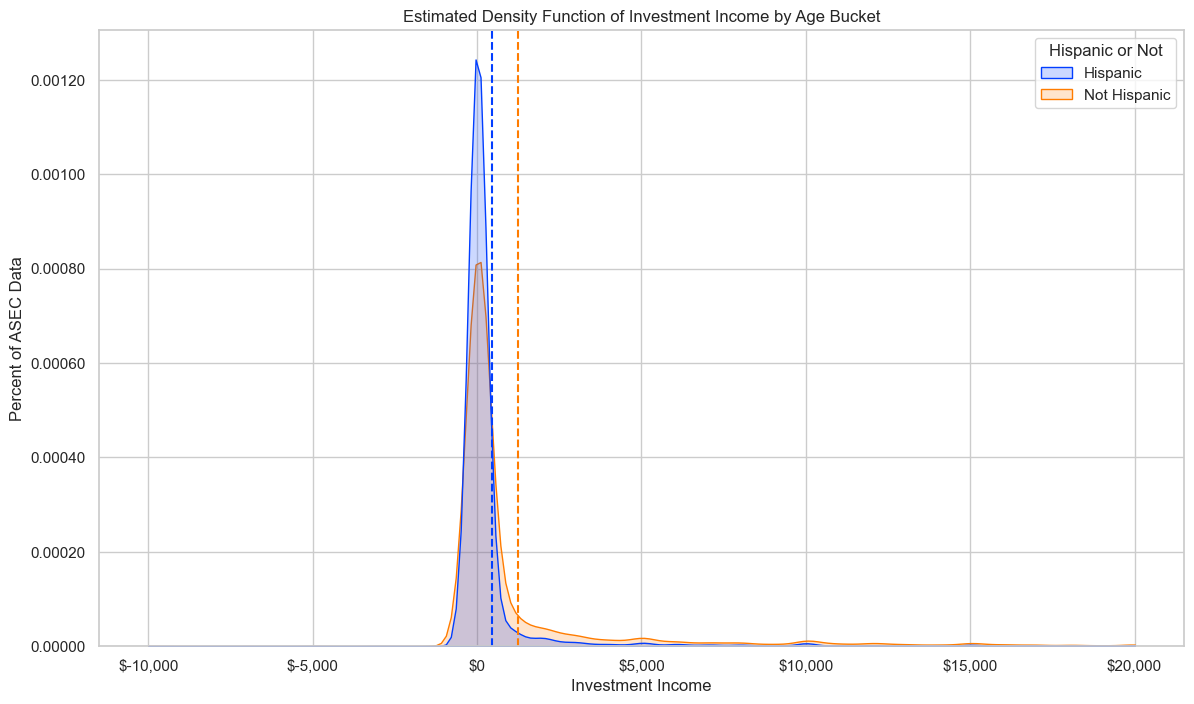

In [19]:
den_plot_by_x(
    ddi_codebook,
    df, 
    'Hispanic or Not',
    'Investment Income', 
    'ASECWT', 
    k=None, bbox=(0.5, -0.01), 
    legend_ncol=10,
    max_percentile=.75,
    addvline=True, 
    den_title='Estimated Density Function of Investment Income for Hispanics vs Non-Hispanics',
)

/Users/franciscojavierarceo/github/pypums/utils.py:463: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Government Income
Hispanic or Not,
Hispanic,2668.712858
Not Hispanic,5713.765440


/Users/franciscojavierarceo/github/pypums/utils.py:504: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



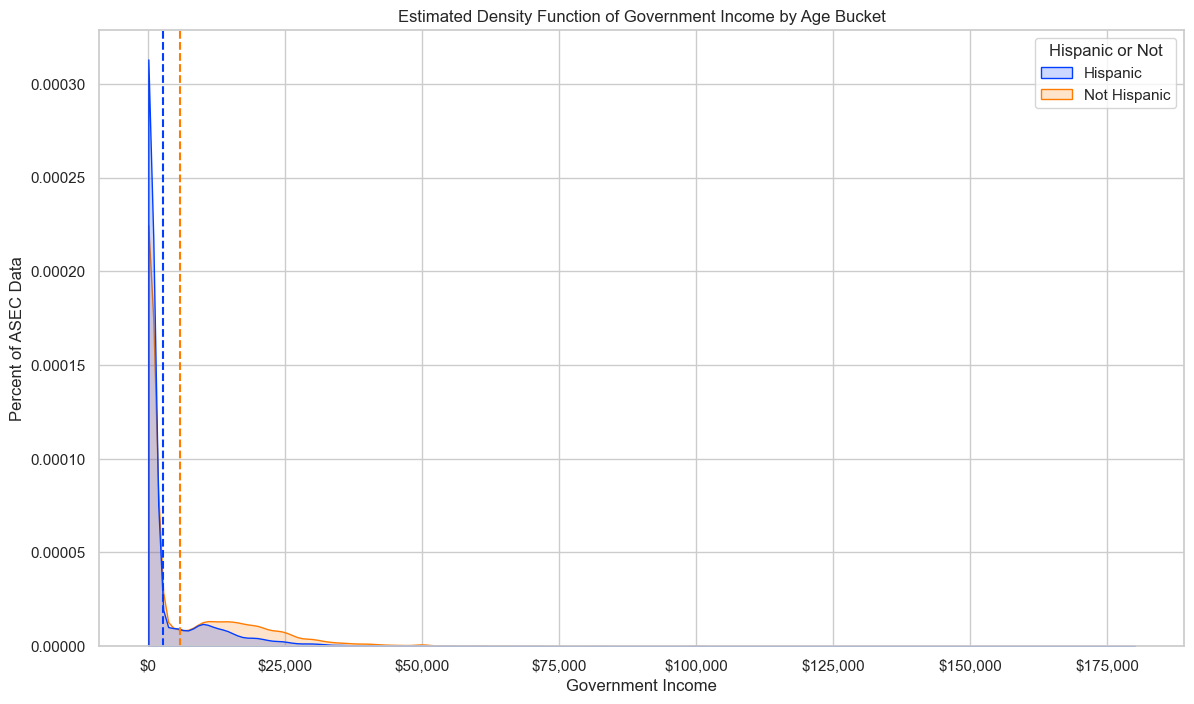

In [20]:
den_plot_by_x(
    ddi_codebook,
    df, 
    'Hispanic or Not',
    'Government Income', 
    'ASECWT', 
    k=None, bbox=(0.5, -0.01), 
    legend_ncol=10,
    max_percentile=.99, 
    addvline=True, 
    den_title='Estimated Density Function of Government Income for Hispanics vs Non-Hispanics',
)

/Users/franciscojavierarceo/github/pypums/utils.py:463: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Age
Hispanic or Not,
Hispanic,26.154039
Not Hispanic,28.749859


/Users/franciscojavierarceo/github/pypums/utils.py:504: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



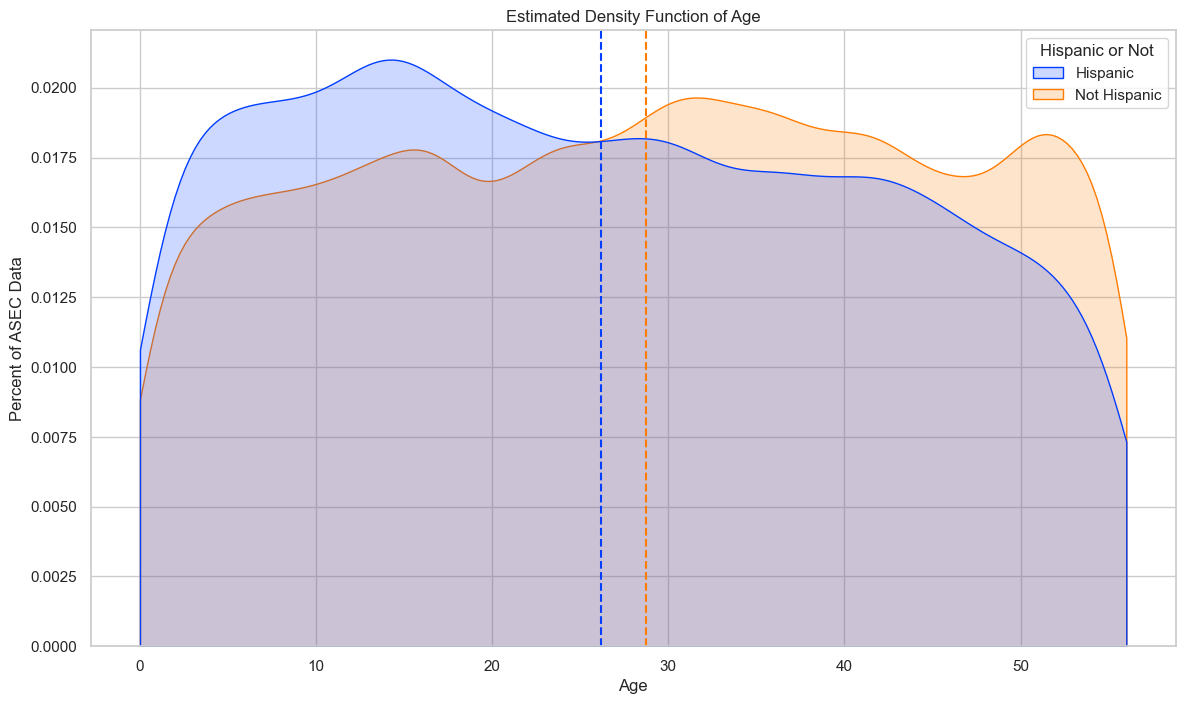

In [21]:
den_plot_by_x(
    ddi_codebook,
    df, 
    'Hispanic or Not',
    'Age', 
    'ASECWT', 
    k=None, bbox=(0.5, -0.01), 
    legend_ncol=10,
    max_percentile=.75,
    addvline=True, 
    den_title='Estimated Density Function of Age',
    format_axis_dollars=False,
)